# Group 7: Mobility Innovators

Group Members:

- Aquiles Escarra
- Inderjeet Singh
- Aditya Mehta
- Yungvir Singh

# 1. Parking Occupancy Prediction – Banff Mobility Project


This notebook supports the final report on parking occupancy prediction for the Town of Banff.
It documents the full modeling process, including data preparation, feature engineering,
model selection, tuning, and visualization of performance results.

Objective:
Predict hourly parking occupancy using temporal and traffic variables to optimize parking management.


# 1. Library Imports

In [110]:
# --- Core packages ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import joblib
import plotly.graph_objects as go


# 2. Load and Explore Data

In [29]:
# --- Load datasets ---
df_ml = pd.read_csv("banff_parking_ml_ready.csv")

# --- Quick inspection ---
print(df_ml.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10447 entries, 0 to 10446
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   datetime                      10447 non-null  object 
 1   vehicles_count                10447 non-null  int64  
 2   hour                          10447 non-null  int64  
 3   day_of_week_num               10447 non-null  int64  
 4   is_weekend                    10447 non-null  int64  
 5   is_holiday_AB                 10447 non-null  int64  
 6   is_holiday_BC                 10447 non-null  int64  
 7   is_holiday_US                 10447 non-null  int64  
 8   is_spring_break               10447 non-null  int64  
 9   is_stampede                   10447 non-null  int64  
 10  max_temp                      10447 non-null  float64
 11  min_temp                      10447 non-null  float64
 12  mean_temp                     10447 non-null  float64
 13  t

In [30]:
df_ml.head()

,datetime,vehicles_count,hour,day_of_week_num,is_weekend,is_holiday_AB,is_holiday_BC,is_holiday_US,is_spring_break,is_stampede,...,EastEntrance_Southbound_lag3,MountainAve_Northbound_lag3,MountainAve_Southbound_lag3,WestEntrance_Northbound_lag3,WestEntrance_Southbound_lag3,rolling_mean_3h,rolling_std_24h,total_downtown_inflow_lag3,total_downtown_outflow_lag3,total_traffic_volume_lag3
0,2024-01-08 19:00:00,180,19,0,0,0,0,0,0,0,...,197.0,78.0,74.0,256.0,322.0,267.333333,123.230953,814.0,773.0,1587.0
1,2024-01-08 20:00:00,114,20,0,0,0,0,0,0,0,...,217.0,64.0,52.0,260.0,367.0,266.666667,115.755482,898.0,846.0,1744.0
2,2024-01-08 21:00:00,1,21,0,0,0,0,0,0,0,...,222.0,70.0,40.0,231.0,266.0,247.666667,106.326601,787.0,832.0,1619.0
3,2024-01-08 22:00:00,1,22,0,0,0,0,0,0,0,...,128.0,55.0,28.0,127.0,154.0,222.000000,98.505462,503.0,516.0,1019.0
4,2024-01-08 23:00:00,1,23,0,0,0,0,0,0,0,...,83.0,38.0,25.0,96.0,78.0,172.000000,95.498682,289.0,375.0,664.0


In [32]:
df_ml['datetime'] = pd.to_datetime(df_ml['datetime'])
df_ml.set_index('datetime', inplace=True)

# 5. Feature Selection

In [74]:
# 2. FEATURE SELECTION FOR LINEAR REGRESSION
# -------------------------------------------------------------------------
# Goal: Remove redundancy so Linear Regression behaves well.

target = 'vehicles_count'

# A. Temporal Features & Binary Flags (We keep these)
feats_time = [
    'hour', 'day_of_week_num', 'month',
    'is_weekend', 'is_holiday_AB', 'is_stampede', 'is_spring_break'
    # Removing minor holidays (US/BC) to simplify the baseline model
]

# B. Weather Features (Choose representatives to avoid redundancy)
# Max, Min, and Mean temperatures move together → keep only Mean Temp.
feats_weather = [
    'mean_temp', 'total_precip', 'snow_on_ground', 'is_bad_weather'
]

# C. Historical Features (LAGS) – The most important ones!
feats_lags = [
    'target_lag3', 'target_lag24', 'target_lag168',
    'rolling_mean_3h'  # Very strong predictor
]

# D. Traffic Features (AGGREGATED instead of individual lanes)
# For Linear Regression, aggregated metrics avoid perfect collinearity
# and reduce noise compared to individual directional counts.
feats_traffic = [
    'total_downtown_inflow_lag3',
    'total_downtown_outflow_lag3',
    'total_traffic_volume_lag3'
]

# FINAL FEATURE LIST (X)
feature_cols = feats_time + feats_weather + feats_lags + feats_traffic

print(f"📊 Selected Features for Baseline ({len(feature_cols)}):")
print(feature_cols)

# Create X and y
X = df_ml[feature_cols]
y = df_ml[target]


📊 Selected Features for Baseline (18):
['hour', 'day_of_week_num', 'month', 'is_weekend', 'is_holiday_AB', 'is_stampede', 'is_spring_break', 'mean_temp', 'total_precip', 'snow_on_ground', 'is_bad_weather', 'target_lag3', 'target_lag24', 'target_lag168', 'rolling_mean_3h', 'total_downtown_inflow_lag3', 'total_downtown_outflow_lag3', 'total_traffic_volume_lag3']


In [75]:
# --- Split 80/20 chronologically ---
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [ ]:
# DEFINE THE FULL FEATURE SET (TREE-FRIENDLY)
# -----------------------------------------------------------
# Recover all available columns from your original dataframe,
# but remove the target and datetime columns.

# Columns to IGNORE (Non-predictive or Target)
cols_ignore = ['vehicles_count', 'datetime']  # Adjust if you have others

# Select all numerical columns
X_full = df_ml.drop(columns=cols_ignore, errors='ignore').select_dtypes(include=[np.number])

print(f"📊 Total Features for Random Forest: {X_full.shape[1]}")
print(X_full.columns.tolist())

# 2. TRAIN/TEST SPLIT WITH FULL FEATURE SET
# -----------------------------------------------------------
# Use the same time-based split to compare apples to apples
split_idx = int(len(X_full) * 0.8)
X_train_full = X_full.iloc[:split_idx]
y_train_full = y.iloc[:split_idx]

X_test_full = X_full.iloc[split_idx:]
y_test_full = y.iloc[split_idx:]

# 6. Baseline & Tuned Models

## Linear Regression (Baseline)

In [90]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

y_pred_lin = lin_model.predict(X_test)

mae_lin = mean_absolute_error(y_test, y_pred_lin)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
r2_lin = r2_score(y_test, y_pred_lin)

print("\n Linear Regression (Baseline)")
print(f"MAE : {mae_lin:.2f}\nRMSE: {rmse_lin:.2f}\nR²  : {r2_lin:.3f}")



 Linear Regression (Baseline)
MAE : 127.66
RMSE: 169.78
R²  : 0.754


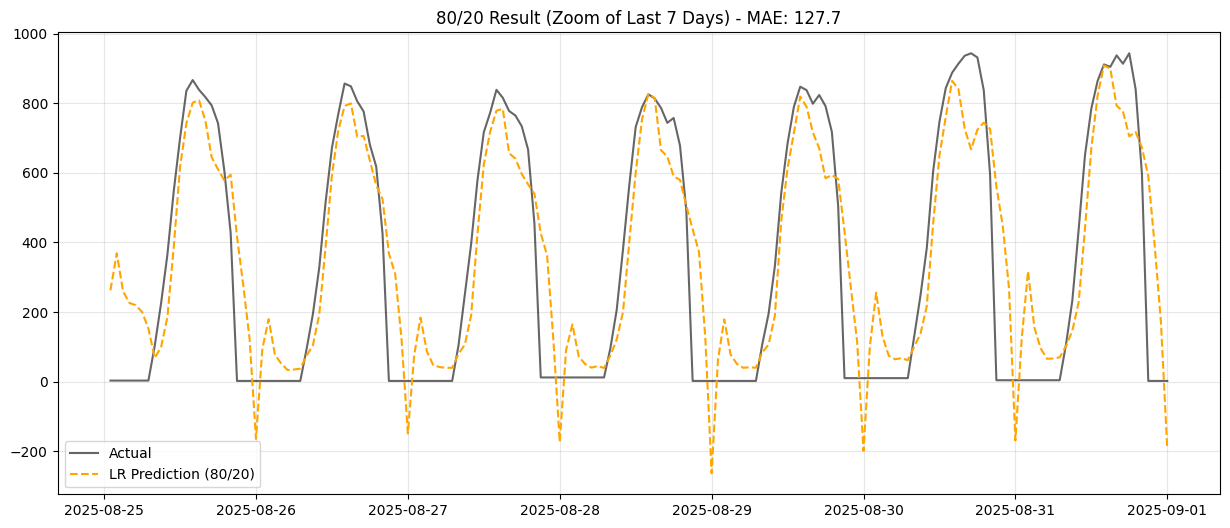

In [91]:
# PLOT (Zoom into the last week of the test set for detailed inspection)
# -----------------------------------------------------
plt.figure(figsize=(15, 6))
days_zoom = 7
limit = 24 * days_zoom

# Plot only the tail of the large test set
plt.plot(y_test.index[-limit:], y_test.values[-limit:], label='Actual', color='black', alpha=0.6)
plt.plot(y_test.index[-limit:], y_pred_lin[-limit:], label='LR Prediction (80/20)', color='orange', linestyle='--')

plt.title(f"80/20 Result (Zoom of Last {days_zoom} Days) - MAE: {mae_lin:.1f}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## Random Forest

In [92]:
# --- Random Forest Model ---
rf_base = RandomForestRegressor(random_state=42)
rf_base.fit(X_train_full, y_train_full)

# --- Evaluation ---
y_pred_rf = rf_base.predict(X_test_full)
mae_rf = mean_absolute_error(y_test_full, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_full, y_pred_rf))
r2_rf = r2_score(y_test_full, y_pred_rf)

print(" Random Forest Base Model Results")
print(f"MAE : {mae_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R²  : {r2_rf:.3f}")

 Random Forest Base Model Results
MAE : 24.21
RMSE: 41.63
R²  : 0.985


## XGBoost

In [108]:
# --- XGBoost Model ---
xgb_base = XGBRegressor(random_state=42, objective="reg:squarederror")
xgb_base.fit(X_train_full, y_train_full)

# --- Evaluation ---
y_pred_xgb = xgb_base.predict(X_test_full)
mae_xgb_base = mean_absolute_error(y_test_full, y_pred_xgb)
rmse_xgb_base = np.sqrt(mean_squared_error(y_test_full, y_pred_xgb))
r2_xgb_base = r2_score(y_test_full, y_pred_xgb)

print(" XGBoost Base Model Results")
print(f"MAE : {mae_xgb_base:.2f}")
print(f"RMSE: {rmse_xgb_base:.2f}")
print(f"R²  : {r2_xgb_base:.3f}")

 XGBoost Base Model Results
MAE : 30.15
RMSE: 48.86
R²  : 0.980


## Base Model Comparison

In [95]:
results_df = pd.DataFrame([
    ["Linear Regression (Baseline)", mae_lin, rmse_lin, r2_lin],
    ["Random Forest", mae_rf, rmse_rf, r2_rf],
    ["XGBoost", mae_xgb_base, rmse_xgb_base, r2_xgb_base]
], columns=["Model", "MAE", "RMSE", "R²"])

print("\n Base Model Comparison")
print(results_df.round(3))




 Base Model Comparison
                          Model      MAE     RMSE     R²
0  Linear Regression (Baseline)  127.657  169.778  0.754
1                 Random Forest   24.208   41.635  0.985
2                       XGBoost   30.148   48.861  0.980


## Feature Importance (Random Forest)


 Random Forest Feature Importance Table (Top 10)
                     Feature  Importance
                        hour    0.695438
 MountainAve_Southbound_lag3    0.148493
                target_lag24    0.042744
             rolling_std_24h    0.025645
                 target_lag3    0.018323
WestEntrance_Northbound_lag3    0.014386
             day_of_week_num    0.012471
EastEntrance_Southbound_lag3    0.005188
             rolling_mean_3h    0.003625
                    max_temp    0.003100


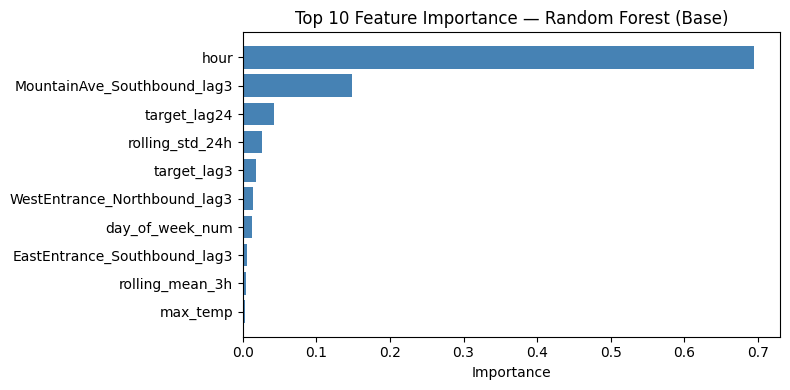

In [98]:
# --- Feature Importance (Random Forest) ---
# Create a DataFrame that pairs each feature with its corresponding importance score
rf_importances = pd.DataFrame({
    "Feature": X_train_full.columns,
    "Importance": rf_base.feature_importances_
}).sort_values("Importance", ascending=False)

# --- Print table neatly (Optional: print only the top 10 as well) ---
# Display the top 10 most important features with nicely formatted decimals
print("\n Random Forest Feature Importance Table (Top 10)")
print(rf_importances.head(10).to_string(index=False, float_format=lambda x: f"{x:.6f}"))

# --- Plot Top 10 ---
# Select only the first 10 rows (top 10 features)
top_10_importances = rf_importances.head(10)

plt.figure(figsize=(8, 4))
# Plot the horizontal bar chart using the filtered DataFrame
plt.barh(top_10_importances["Feature"], top_10_importances["Importance"], color="steelblue")
plt.gca().invert_yaxis()  # Keep the most important feature at the top
plt.title("Top 10 Feature Importance — Random Forest (Base)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [97]:
rf_importances["Feature"].unique()

array(['hour', 'MountainAve_Southbound_lag3', 'target_lag24',
       'rolling_std_24h', 'target_lag3', 'WestEntrance_Northbound_lag3',
       'day_of_week_num', 'EastEntrance_Southbound_lag3',
       'rolling_mean_3h', 'max_temp', 'total_downtown_outflow_lag3',
       'month', 'min_temp', 'EastEntrance_Northbound_lag3', 'mean_temp',
       'is_weekend', 'WestEntrance_Southbound_lag3',
       'MountainAve_Northbound_lag3', 'Bridge_Northbound_lag3',
       'target_lag168', 'total_traffic_volume_lag3',
       'total_downtown_inflow_lag3', 'Bridge_Southbound_lag3',
       'snow_on_ground', 'total_precip', 'is_holiday_AB', 'is_holiday_BC',
       'has_precip', 'is_spring_break', 'is_bad_weather', 'is_holiday_US',
       'is_stampede'], dtype=object)

### Feature Selection

In [99]:
top_features = [
    'hour',                        # The King (explains ~70% of the signal)
    'MountainAve_Southbound_lag3', # Key tourist inflow into downtown
    'target_lag24',                # Daily inertia (same hour yesterday)
    'target_lag3',                 # Short-term inertia (last 3 hours)
    'rolling_std_24h',             # 24-hour volatility
    'WestEntrance_Northbound_lag3',# Outflow toward the west highway
    'day_of_week_num',             # Weekly cycle pattern
    'EastEntrance_Southbound_lag3',# Inflow from the east entrance
    'rolling_mean_3h',             # Smoothed recent trend
    'max_temp',                    # Weather influence (temperature representative)
    'month'                        # Annual seasonality (helps with seasonal transitions)
]

print(f"   Selected variables: {len(top_features)}")
print(f"   Discarded: {X_train_full.shape[1] - len(top_features)} noise variables.")

   Selected variables: 11
   Discarded: 21 noise variables.


In [100]:
# FILTER THE DATASETS
# -----------------------------------------------------------
# Keep only the top selected features (lean feature set)
X_train_lean = X_train_full[top_features].copy()
X_test_lean = X_test_full[top_features].copy()


## Random Forest — Hyperparameter Tuning

In [101]:
print("🔧 STARTING HYPERPARAMETER OPTIMIZATION (RF)...")

# 1. DEFINE THE SEARCH SPACE (The “aisles” of options to explore)
# -----------------------------------------------------------
param_dist = {
    'n_estimators': [200, 300, 500, 800],        # More trees = better stability, but slower
    'max_depth': [None, 10, 20, 30],             # None = grow trees fully (risk of overfitting)
    'min_samples_split': [2, 5, 10],             # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],               # Minimum samples required in a final leaf
    'max_features': ['sqrt', 1.0],               # 'sqrt' reduces variance; 1.0 uses all features
    'bootstrap': [True, False]                   # Sampling with or without replacement
}

# 2. CONFIGURE TIME-SERIES CROSS-VALIDATION
# -----------------------------------------------------------
# We split history into 5 sequential folds.
# Fold 1: small train → next month as validation
# ...
# Fold 5: large train → last month as validation
tscv = TimeSeriesSplit(n_splits=5)

# 3. SET UP THE SEARCH ENGINE (RandomizedSearchCV)
# -----------------------------------------------------------
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=30,                          # Will test 30 random parameter combinations
    scoring='neg_mean_absolute_error',  # Scikit-learn maximizes scores → negative MAE
    cv=tscv,                            # STRICT time-series CV
    verbose=1,                          # Show progress logs
    random_state=42,
    n_jobs=-1                           # Use all CPU cores
)

# 4. EXECUTE THE TUNING (Training...)
# -----------------------------------------------------------
# We use the full training set (X_train_full) defined earlier
print(f"⏳ Training and validating 30 combinations across 5 temporal folds...")
random_search.fit(X_train_lean, y_train_full)

# 5. TUNING RESULTS
# -----------------------------------------------------------
best_rf = random_search.best_estimator_
best_mae_cv = -random_search.best_score_   # Convert from negative MAE to positive

print(f"\n🎉 Tuning Completed!")
print(f"   > Best Average MAE in Validation: {best_mae_cv:.2f} vehicles")
print(f"   > Best Parameters Found:")
print(random_search.best_params_)

# 6. FINAL FIRE TEST (On the Reserved Test Set)
# -----------------------------------------------------------
# Use the winning model to predict on the test set (last 14 days)
preds_tuned = best_rf.predict(X_test_lean)
mae_tuned = mean_absolute_error(y_test_full, preds_tuned)

print(f"\n🏆 FINAL IMPACT (14-Day Test Window):")
print(f"   > MAE Original Model (Untuned): 24.208 vehicles (prior result)")
print(f"   > MAE Tuned/Optimized Model:   {mae_tuned:.2f} vehicles")

if mae_tuned < 24.208:
    print("✅ CONCLUSION: Optimization improved the model. This version will be kept.")
else:
    print("⚠️ CONCLUSION: Default parameters were already strong. Improvement is marginal.")


🔧 STARTING HYPERPARAMETER OPTIMIZATION (RF)...
⏳ Training and validating 30 combinations across 5 temporal folds...
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



🎉 Tuning Completed!
   > Best Average MAE in Validation: 31.89 vehicles
   > Best Parameters Found:
{'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 1.0, 'max_depth': None, 'bootstrap': True}

🏆 FINAL IMPACT (14-Day Test Window):
   > MAE Original Model (Untuned): 24.208 vehicles (prior result)
   > MAE Tuned/Optimized Model:   23.66 vehicles
✅ CONCLUSION: Optimization improved the model. This version will be kept.


🧠 Training Final Random Forest with optimal parameters...

--- FINAL MODEL RESULTS ---
🥇 MAE (Mean Absolute Error): 23.66 vehicles
📈 RMSE (Root Mean Squared Error): 40.85
🎯 R² (Explained Variance): 0.9857
-----------------------------------


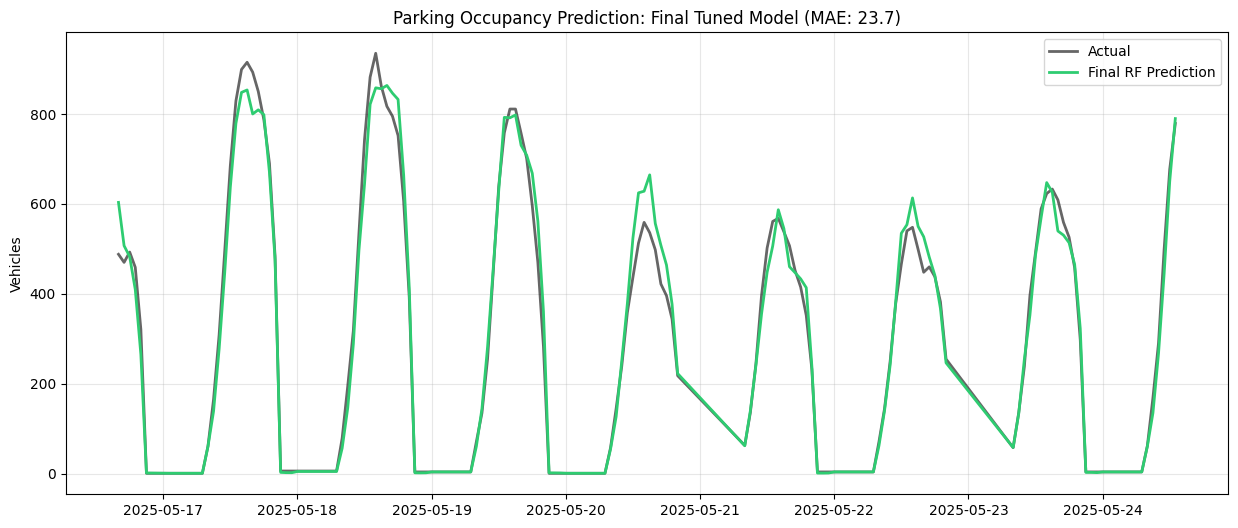


✅ The final model has been trained and saved.


In [105]:
# Definition of the model using the best parameters found during hyperparameter search
best_params = {
    'n_estimators': 800,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 1.0,
    'max_depth': None,
    'bootstrap': True,
    'random_state': 42,
    'n_jobs': -1
}

print("🧠 Training Final Random Forest with optimal parameters...")

# 1. FINAL TRAINING (Using the best parameters)
# ----------------------------------------------------
rf_final_model = RandomForestRegressor(**best_params)

# Train using the full training set
rf_final_model.fit(X_train_lean, y_train_full)

# 2. PREDICTION ON THE TEST SET (Validation)
# ----------------------------------------------------
y_pred_final = rf_final_model.predict(X_test_lean)
y_pred_final = np.maximum(y_pred_final, 0)  # Ensure no negative predictions

# 3. METRIC CALCULATION
# ----------------------------------------------------
mae_final = mean_absolute_error(y_test_full, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_test_full, y_pred_final))
r2_final = r2_score(y_test_full, y_pred_final)

# 4. EXPORT THE WINNING MODEL (Save the final version)
# ----------------------------------------------------
joblib.dump(rf_final_model, "banff_parking_rf_final_optimized_2366.joblib")

print("\n--- FINAL MODEL RESULTS ---")
print(f"🥇 MAE (Mean Absolute Error): {mae_final:.2f} vehicles")
print(f"📈 RMSE (Root Mean Squared Error): {rmse_final:.2f}")
print(f"🎯 R² (Explained Variance): {r2_final:.4f}")
print("-----------------------------------")


## 5. VISUALIZATION OF OPERATIONAL PREDICTION
plt.figure(figsize=(15, 6))
days_to_plot = 7
limit = 24 * days_to_plot

plt.plot(y_test_full.index[:limit], y_test_full.values[:limit],
         label='Actual', color='black', alpha=0.6, linewidth=2)

plt.plot(y_test_full.index[:limit], y_pred_final[:limit],
         label='Final RF Prediction', color='#2ecc71', linewidth=2)  # Bright green for the champion

plt.title(f"Parking Occupancy Prediction: Final Tuned Model (MAE: {mae_final:.1f})")
plt.ylabel("Vehicles")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n✅ The final model has been trained and saved.")


## XGBoost — Hyperparameter Tuning

In [103]:
# --- Parameter grid for randomized search ---
param_grid_xgb = {
    "n_estimators": [500, 1000, 1500],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "gamma": [0, 0.5, 1],
    "min_child_weight": [1, 2, 5],
    "reg_lambda": [0.1, 0.5, 1],
    "reg_alpha": [0.001, 0.01, 0.1],
}

# --- Time-series cross-validation (temporal order preserved) ---
tscv = TimeSeriesSplit(n_splits=5)

# --- RandomizedSearchCV setup ---
xgb_search = RandomizedSearchCV(
    estimator=XGBRegressor(
        random_state=42,
        objective="reg:absoluteerror",
        n_jobs=-1
    ),
    param_distributions=param_grid_xgb,
    n_iter=30,                              # 30 randomized parameter combinations
    cv=tscv,
    scoring="neg_mean_absolute_error",      # optimize for lowest MAE
    verbose=1
)

# --- Fit the search ---
xgb_search.fit(X_train_lean, y_train)

# --- Display best parameters ---
print(" Best XGBoost Parameters:")
print(xgb_search.best_params_)
print(f"Best CV MAE: {abs(xgb_search.best_score_):.2f}")

# --- Evaluate tuned model on the test set ---
best_xgb = xgb_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_lean)

# --- Compute evaluation metrics ---
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\n XGBoost Simplified — Tuned Performance")
print(f"MAE : {mae_xgb:.2f}")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"R²  : {r2_xgb:.3f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
 Best XGBoost Parameters:
{'subsample': 1.0, 'reg_lambda': 0.5, 'reg_alpha': 0.1, 'n_estimators': 1000, 'min_child_weight': 2, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 1, 'colsample_bytree': 1.0}
Best CV MAE: 29.03

 XGBoost Simplified — Tuned Performance
MAE : 24.26
RMSE: 41.63
R²  : 0.985


## Create Comparison Table

In [111]:
# --- Model results (using your actual values) ---
results = pd.DataFrame({
    "Model": [
        "Linear Regression (Baseline)",
        "Random Forest (Base)",
        "Random Forest (Simplified — Tuned)",
        "XGBoost (Base)",
        "XGBoost (Simplified — Tuned)"
    ],
    "MAE":  [round(mae_lin, 2), round(mae_rf, 2), round(mae_final, 2), round(mae_xgb_base, 2), round(mae_xgb, 2)],
    "RMSE": [round(rmse_lin, 2), round(rmse_rf, 2), round(rmse_final, 2), round(rmse_xgb_base, 2), round(rmse_xgb, 2)],
    "R2":   [round(r2_lin, 3),  round(r2_rf, 3),  round(r2_final, 3),   round(r2_xgb_base, 3),   round(r2_xgb, 3)]
})

# Convert R2 to numeric (safety)
results["R2"] = results["R2"].astype(float)

# --- Create horizontal bar chart with Plotly ---
fig = go.Figure()

# Add MAE bars
fig.add_trace(go.Bar(
    y=results["Model"],
    x=results["MAE"],
    name="MAE (Mean Absolute Error)",
    orientation='h',
    marker_color="steelblue",
    text=[f"{v:.2f}" for v in results["MAE"]],
    textposition="outside"
))

# Add RMSE bars
fig.add_trace(go.Bar(
    y=results["Model"],
    x=results["RMSE"],
    name="RMSE (Root Mean Squared Error)",
    orientation='h',
    marker_color="darkorange",
    text=[f"{v:.2f}" for v in results["RMSE"]],
    textposition="outside"
))

# Add R² bars (scaled to 0–100)
fig.add_trace(go.Bar(
    y=results["Model"],
    x=[v * 100 for v in results["R2"]],
    name="R² (%)",
    orientation='h',
    marker_color="green",
    text=[f"{v*100:.2f}%" for v in results["R2"]],
    textposition="outside"
))

# --- Layout customization ---
fig.update_layout(
    title="Baseline vs Tuned Model Performance — MAE, RMSE, and R²",
    xaxis_title="Error / Score",
    yaxis_title="Model",
    template="plotly_white",
    barmode="group",
    height=550,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.3,
        xanchor="center",
        x=0.5
    ),
    font=dict(size=12)
)

fig.show()


# Conclusions

The minor performance differences between the tuned models and their baseline versions (e.g., Base RF vs. Tuned RF) are marginal, indicating that Random Forest’s default parameters were already highly effective. The selected feature set—after removing the long tail of noisy variables—provides an optimal balance between interpretability and predictive strength. This results in a robust and scalable foundation for real-time occupancy forecasting and data-driven parking management in Banff.